In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T
import pandas as pd
from typing import Optional
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler, Imputer, MinMaxScaler
from pyspark.ml.stat import Correlation
import matplotlib.pyplot as plt
import seaborn as sns

Data cleaning and feature engineering steps taken:

- Sanitise column names:
    - lower the case
    - fix punctuation, spacing, nonprintable characters

- Remove illogical and irrelevant records

- Remove macronutrient values above the 99th percentile

- Create ratio features (proprortions of calories made up by each macronutrient)

- Impute the mean of continuous features

In [2]:
# Allocate 8GB of RAM to the driver
spark = (
    SparkSession.builder.appName("Dessert or Not?")
    .config("spark.driver.memory", "8g")
    .getOrCreate()
)

# Set the maximum number of pd rows to display to make data exploration easier
pd.set_option("display.max_rows", 1000) 


### Exploratory Data Analysis

In [3]:
food = spark.read.csv('./data/epi_r.csv', inferSchema=True, header=True)

print(food.count(), len(food.columns))

food.printSchema()

20057 680
root
 |-- title: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- calories: string (nullable = true)
 |-- protein: double (nullable = true)
 |-- fat: double (nullable = true)
 |-- sodium: double (nullable = true)
 |-- #cakeweek: double (nullable = true)
 |-- #wasteless: double (nullable = true)
 |-- 22-minute meals: double (nullable = true)
 |-- 3-ingredient recipes: double (nullable = true)
 |-- 30 days of groceries: double (nullable = true)
 |-- advance prep required: double (nullable = true)
 |-- alabama: double (nullable = true)
 |-- alaska: double (nullable = true)
 |-- alcoholic: double (nullable = true)
 |-- almond: double (nullable = true)
 |-- amaretto: double (nullable = true)
 |-- anchovy: double (nullable = true)
 |-- anise: double (nullable = true)
 |-- anniversary: double (nullable = true)
 |-- anthony bourdain: double (nullable = true)
 |-- aperitif: double (nullable = true)
 |-- appetizer: double (nullable = true)
 |-- apple: double (nullabl

Many columns contain undesirable characters such as # (from hashtags), and invalid characters. These should be standardised.

In [4]:
def sanitize_column_name(name):
    """Remove unwanted characters from a column name."""
    out = name
    for i, j in ((" ", "_"), ("-", "_"), ("/", "_"), ("&", "and")):
        out = out.replace(i, j)
    # Keep only letters, numbers and underscores
    return "".join(
        [char for char in out if char.isalpha() or char.isdigit() or char == "-"]
    )

In [5]:
food = food.toDF(*[sanitize_column_name(name) for name in food.columns])

Identify binary columns 

In [6]:
is_binary = food.agg(
    # If the number of distinct values in the column is 2, then it's probably binary
    *[(F.size(F.collect_set(x)) == 2).alias(x) for x in food.columns]
).toPandas()

# Unpivot the dataframe to make it easier to read in the terminal
is_binary.unstack().sort_values()

title                  0    False
rating                 0    False
calories               0    False
protein                0    False
fat                    0    False
sodium                 0    False
cakeweek               0    False
wasteless              0    False
passionfruit           0     True
passover               0     True
pasta                  0     True
pastamaker             0     True
pastry                 0     True
pea                    0     True
peach                  0     True
peanut                 0     True
pecan                  0     True
peanutfree             0     True
pear                   0     True
pasadena               0     True
pennsylvania           0     True
pepper                 0     True
pernod                 0     True
persiannewyear         0     True
persimmon              0     True
peanutbutter           0     True
party                  0     True
paris                  0     True
parsley                0     True
orange        

`cakeweek` and `wasteless` do not appear to be binary:

In [7]:
# Show the distinct values for the suspect columns
food.agg(*[F.collect_set(x) for x in ("cakeweek", "wasteless")]).show(1, False)

# Show the first and last few records with non-binary values to check for data alignment issues
(
    food
    .where("cakeweek > 1.0 or wasteless > 1.0")
    .select("title", "rating", "wasteless", "cakeweek", food.columns[-1])
    .show(truncate=False)
)

+-------------------------------+----------------------+
|collect_set(cakeweek)          |collect_set(wasteless)|
+-------------------------------+----------------------+
|[0.0, 1.0, 1188.0, 24.0, 880.0]|[0.0, 1.0, 1439.0]    |
+-------------------------------+----------------------+

+----------------------------------------------------------------+------------------------+---------+--------+------+
|title                                                           |rating                  |wasteless|cakeweek|turkey|
+----------------------------------------------------------------+------------------------+---------+--------+------+
|"Beet Ravioli with Pine Nut ""Goat Cheese"" Rosemary-Cream Sauce| Aged Balsamic Vinegar "|0.0      |880.0   |0.0   |
|"Seafood ""Cataplana"" with Saffron                             | Vermouth               |1439.0   |24.0    |0.0   |
|"""Pot Roast"" of Seitan                                        | Aunt Gloria-Style "    |0.0      |1188.0  |0.0   |
+-----

Since this is only a small number of records compared to the total dataset size, we remove them.

In [8]:
# Keep only legit values for cakeweek and wasteless
food = (
    food.where(
        (F.col("cakeweek").isin([0.0, 1.0]) | F.col("cakeweek").isNull())
        &
        (F.col("wasteless").isin([0.0, 1.0]) | F.col("wasteless").isNull())   
    )
)

print(food.count(), len(food.columns))

20054 680


Classifying variable types

In [9]:
# Columns containing information unique to each record
IDENTIFIERS = ["title"]

# Columns containing ML features
CONTINUOUS_COLUMNS = [
    "rating",
    "calories",
    "protein",
    "fat",
    "sodium"
]

# Columns containing the features we wish to predict
TARGET_COLUMN = ["dessert"]

# Columns containing binary features
BINARY_COLUMNS = [
    x for x in food.columns 
    if x not in CONTINUOUS_COLUMNS 
    and x not in TARGET_COLUMN
    and x not in IDENTIFIERS
]

We remove records that have only `null` values. After that, we equate `null` to `False` and fill zero as a default value. 

In [10]:
# Remove records that have only null values
food = food.dropna(
    how="all",
    subset=[x for x in food.columns if x not in IDENTIFIERS]
)

food = food.dropna(subset=TARGET_COLUMN)

print(food.count(), len(food.columns))

20049 680


In [11]:
food = food.fillna(0.0, subset=BINARY_COLUMNS)

print(food.where(F.col(BINARY_COLUMNS[0]).isNull()).count())

0


Cleaning continuous columns

In [12]:
# If the value is not null, try casting it to a float.
# If this fails, it's not a number.
@F.udf(T.BooleanType())
def is_a_number(value: Optional[str]) -> bool:
    if not value:
        return True
    try:
        _ = float(value)
    except ValueError:
        return False
    return True

In [13]:
# Show non-numerical values in the continuous columns
food.where(~is_a_number(F.col("rating"))).select(*CONTINUOUS_COLUMNS).show()

+---------+------------+-------+----+------+
|   rating|    calories|protein| fat|sodium|
+---------+------------+-------+----+------+
| Cucumber| and Lemon "|   3.75|null|  null|
+---------+------------+-------+----+------+



In [14]:
# Remove rogue continuous column values, cast remaining values to double
for column in CONTINUOUS_COLUMNS:
    food = food.where(is_a_number(F.col(column)))
    food = food.withColumn(column, F.col(column).cast(T.DoubleType()))

print(food.count(), len(food.columns))

20048 680


We examine the summary statistics of our continuous columns to look for remaining non-sensible values.

In [15]:
food.select(CONTINUOUS_COLUMNS).summary(
    "mean",
    "stddev",
    "min",
    "1%",
    "5%",
    "50%",
    "95%",
    "99%",
    "max"
).show()

+-------+------------------+------------------+------------------+-----------------+-----------------+
|summary|            rating|          calories|           protein|              fat|           sodium|
+-------+------------------+------------------+------------------+-----------------+-----------------+
|   mean| 3.714460295291301|6324.0634571930705|100.17385283565179|346.9398083953107|6226.927244193346|
| stddev|1.3409187660508959|359079.83696340164|3840.6809971287403|20458.04034412409|333349.5680370268|
|    min|               0.0|               0.0|               0.0|              0.0|              0.0|
|     1%|               0.0|              18.0|               0.0|              0.0|              1.0|
|     5%|               0.0|              62.0|               0.0|              0.0|              5.0|
|    50%|             4.375|             331.0|               8.0|             17.0|            294.0|
|    95%|               5.0|            1315.0|              75.0|       

Some remaining nutrition values are very high (way higher than the 75th percentile). We cap the values at the 99th percentile.

In [16]:
# Remove rows with values above the 99th percentile.
# Use hardcoded maxima to ensure analysis is consistent across runs.
maximum = {
    "calories": 3184.0,
    "protein": 173.0,
    "fat": 207.0,
    "sodium": 5649.0
}

# Replace large values while holding onto null values:
for k, v in maximum.items():
    food = food.withColumn(
        k,
        F.when(F.isnull(F.col(k)), F.col(k)).otherwise(
            F.least(F.col(k), F.lit(v))
        )
    )   

Weed out binary columns which are not present enough to be reliable predictors. 

In [17]:
# Remove binary features that occur too little or too often
# We choose a threshold of 10.
inst_sum_of_binary_columns = [
    F.sum(F.col(x)).alias(x) for x in BINARY_COLUMNS
]

# Using .head() brings data back from the distributed cluster
# to the Spark driver
sum_of_binary_columns = (
    food.select(*inst_sum_of_binary_columns).head().asDict()
)

num_rows = food.count()
# If the count of the ones / sum of the column is below 10 or above
# the number of records - 10, we remove the column.
too_rare_features = [
    k for k, v in sum_of_binary_columns.items()
    if v < 10 or v > (num_rows - 10)
]

# Rather than deleting the columns from the food dataframe, we remove
# them from the BINARY_COLUMNS list
BINARY_COLUMNS = list(set(BINARY_COLUMNS) - set(too_rare_features))

len(too_rare_features)

print(too_rare_features)

['cakeweek', 'wasteless', '30daysofgroceries', 'alabama', 'alaska', 'anthonybourdain', 'applejuice', 'arizona', 'aspen', 'atlanta', 'australia', 'beverlyhills', 'biscuit', 'boston', 'bran', 'brooklyn', 'brownie', 'buffalo', 'bulgaria', 'burrito', 'cambridge', 'camping', 'canada', 'caviar', 'chicago', 'chili', 'cobblercrumble', 'columbus', 'cooklikeadiner', 'cookbookcritic', 'costamesa', 'cranberrysauce', 'crêpe', 'crmedecacao', 'cuba', 'cupcake', 'custard', 'dallas', 'denver', 'digestif', 'dominicanrepublic', 'doriegreenspan', 'eaudevie', 'eggnog', 'egypt', 'emerillagasse', 'england', 'entertaining', 'epiushg', 'epilovesthemicrowave', 'flatbread', 'frankenrecipe', 'freezerfood', 'friendsgiving', 'frittata', 'fritter', 'germany', 'grains', 'grandmarnier', 'granola', 'grappa', 'guam', 'haiti', 'hamburger', 'hawaii', 'healdsburg', 'hollywood', 'housecocktail', 'houston', 'hummus', 'icedcoffee', 'idaho', 'illinois', 'indiana', 'iowa', 'israel', 'italy', 'jamaica', 'japan', 'juicer', 'kansa

Feature engineering and refinement

- Create a few custom features using continuous feature columns
- Measure correlation between original and generated continuous features

Since we know that there are 4kcal per g of protein and 9kcal per g of fat, we can create feature columns representing the proportion of the recipe's calories that are made up by protein and fat. Perhaps desserts have a higher proportion of fat calories?

In [18]:
# Create columns representing the proportion of calories contributed
# by protein and fat
food = (
    food
    .withColumn("protein_ratio", F.col("protein") * 4 / F.col("calories"))
    .withColumn("fat_ratio", F.col("fat") * 9 / F.col("calories"))
)

# Fill the columns where NA
food.fillna(0.0, subset=["protein_ratio", "fat_ratio"])

# Add the new columns to the CONTINUOUS_COLUMNS list
CONTINUOUS_COLUMNS += ["protein_ratio", "fat_ratio"]

Removing highly correlated features

The `Correlation` object's `corr` method computes the correlation between features in a `Vector`.

We use the `VectorAssembler` transformer to create a `continuous_features` column containing a `Vector` of continuous features.

Correlation won't work well if we blend categorical and/or binary features together. Correlation coefficients, such as Pearson correlation coefficient, are used to quantify the strength and direction of a linear relationship between two numerical variables. They are not suitable for categorical or binary variables because these types of variables do not have a natural linear ordering or continuous values.

In [19]:
continuous_features = VectorAssembler(
    inputCols=CONTINUOUS_COLUMNS, outputCol="continuous_features"
)

# Prepare continuous columns to be transformed into a vector.
# Vector columns can't have null values, so we remove them
vector_food = food.select(CONTINUOUS_COLUMNS)
for x in CONTINUOUS_COLUMNS:
    vector_food = vector_food.where(~F.isnull(F.col(x)))

vector_variable = continuous_features.transform(vector_food)

vector_variable.select("continuous_features").show(3, False)

vector_variable.select("continuous_features").printSchema()

+---------------------------------------------------------------------+
|continuous_features                                                  |
+---------------------------------------------------------------------+
|[2.5,426.0,30.0,7.0,559.0,0.28169014084507044,0.14788732394366197]   |
|[4.375,403.0,18.0,23.0,1439.0,0.17866004962779156,0.5136476426799007]|
|[3.75,165.0,6.0,7.0,165.0,0.14545454545454545,0.38181818181818183]   |
+---------------------------------------------------------------------+
only showing top 3 rows

root
 |-- continuous_features: vector (nullable = true)



In [20]:
# Take a data frame and a Vector column and generate a single-row,
# single-column data frame containing the correlation matrix
# Uses Pearson correlation coefficient by default.
correlation = Correlation.corr(
    vector_variable, "continuous_features"
)

correlation.printSchema()

root
 |-- pearson(continuous_features): matrix (nullable = false)



In [21]:
# The resulting DenseMatrix is a column in a row in a Pyspark DataFrame.
# It is small enough to retrieve to the driver node using collect().
print(correlation.collect()[0][0])

DenseMatrix([[1.        , 0.10220829, 0.11315532, 0.11135616, 0.06561056,
              0.09412346, 0.12947093],
             [0.10220829, 1.        , 0.75817328, 0.91809823, 0.5170557 ,
              0.16501637, 0.17709785],
             [0.11315532, 0.75817328, 1.        , 0.66480495, 0.58562236,
              0.6003379 , 0.10906338],
             [0.11135616, 0.91809823, 0.66480495, 1.        , 0.42208754,
              0.1254943 , 0.42534458],
             [0.06561056, 0.5170557 , 0.58562236, 0.42208754, 1.        ,
              0.33943422, 0.03396702],
             [0.09412346, 0.16501637, 0.6003379 , 0.1254943 , 0.33943422,
              1.        , 0.02374545],
             [0.12947093, 0.17709785, 0.10906338, 0.42534458, 0.03396702,
              0.02374545, 1.        ]])


In [22]:
correlation_array = correlation.collect()[0][0].toArray()
correlation_pd = pd.DataFrame(
    correlation_array,
    index = CONTINUOUS_COLUMNS,
    columns = CONTINUOUS_COLUMNS
)

In [23]:
# Show the Pearson correlations
print(correlation_pd)

                 rating  calories   protein       fat    sodium  \
rating         1.000000  0.102208  0.113155  0.111356  0.065611   
calories       0.102208  1.000000  0.758173  0.918098  0.517056   
protein        0.113155  0.758173  1.000000  0.664805  0.585622   
fat            0.111356  0.918098  0.664805  1.000000  0.422088   
sodium         0.065611  0.517056  0.585622  0.422088  1.000000   
protein_ratio  0.094123  0.165016  0.600338  0.125494  0.339434   
fat_ratio      0.129471  0.177098  0.109063  0.425345  0.033967   

               protein_ratio  fat_ratio  
rating              0.094123   0.129471  
calories            0.165016   0.177098  
protein             0.600338   0.109063  
fat                 0.125494   0.425345  
sodium              0.339434   0.033967  
protein_ratio       1.000000   0.023745  
fat_ratio           0.023745   1.000000  


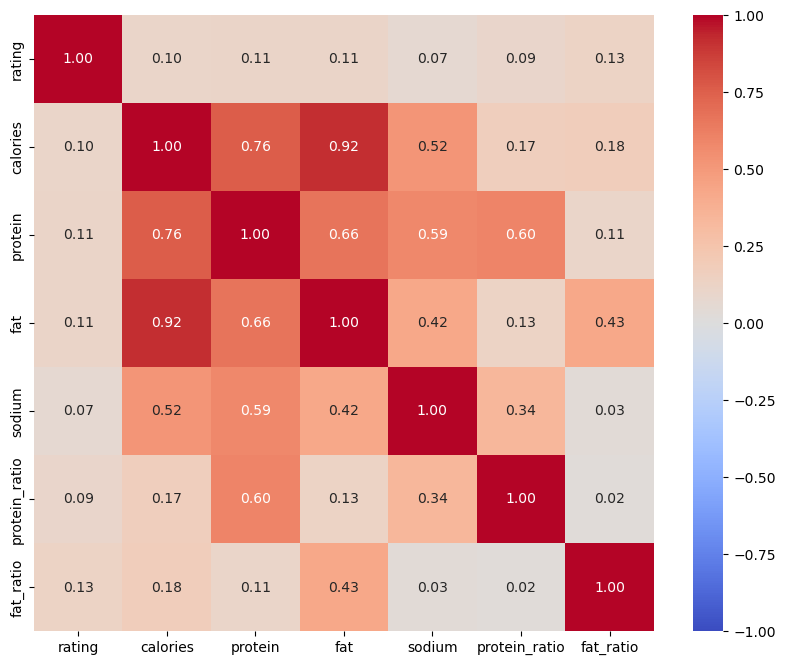

In [24]:
# Set the size of the figure for better visibility (adjust as needed)
plt.figure(figsize=(10, 8))

# Define the colormap to use (e.g., 'coolwarm', 'viridis', 'plasma', 'RdYlBu', etc.)
colormap = 'coolwarm'

# Display the heatmap with the specified colormap
sns.heatmap(correlation_pd, cmap=colormap, annot=True, fmt=".2f", vmin=-1, vmax=1)

# Show the plot
plt.show()

We see high correlation between sodium, calories, protein and fat.

- What's the relationship between calorie count and the ratio of macronutrients?
- How do calories, protein, fat and sodium relate to being a dessert or not?

Feature preparation

In [25]:
# Instantiate and apply an Imputer to create an ImputerModel

OLD_COLS = ["calories", "protein", "fat", "sodium"]
NEW_COLS = ["calories_i", "protein_i", "fat_i", "sodium_i"]

# Create imputer using mean to fill null values
imputer = Imputer(
    strategy="mean",
    inputCols=OLD_COLS,
    outputCols=NEW_COLS
)

# Create ImputerModel by applying fit() method to food DataFrame
imputer_model = imputer.fit(food)

# Put NEW_COLS into CONTINUOUS_COLUMNS, remove OLD_COLS
CONTINUOUS_COLUMNS = (
    list(set(CONTINUOUS_COLUMNS) - set(OLD_COLS)) + NEW_COLS
)

In [26]:
# Use the ImputerModel on the food DataFrame
food_imputed = imputer_model.transform(food)

In [27]:
food_imputed.where("calories is null").select("calories", "calories_i").show(5, False)

+--------+------------------+
|calories|calories_i        |
+--------+------------------+
|null    |475.33021591765004|
|null    |475.33021591765004|
|null    |475.33021591765004|
|null    |475.33021591765004|
|null    |475.33021591765004|
+--------+------------------+
only showing top 5 rows



Scale features using MinMaxScaler estimator

```Rescaled(e_i) = (e_i - E_min) / (E_max - E_min) * (max - min) + min```

In [28]:
# Scale continuous (non-ratio) variables (ratios are already between 0 and 1)
CONTINUOUS_NB = [x for x in CONTINUOUS_COLUMNS if "ratio" not in x]

# VectorAssembler is a transformer
continuous_assembler = VectorAssembler(
    inputCols = CONTINUOUS_NB, outputCol="continuous"
)

food_features = continuous_assembler.transform(food_imputed)

# MinMaxScaler is an estimator and needs to be fitted on the data
# Before it can transform anything.
# Use default values of min=0.0 and max=1.0
continuous_scaler = MinMaxScaler(
    inputCol="continuous",
    outputCol="continuous_scaled"
)

food_features = continuous_scaler.fit(food_features).transform(food_features)

food_features.select("continuous_scaled").show(3, False)

+----------------------------------------------------------------------------------------+
|continuous_scaled                                                                       |
+----------------------------------------------------------------------------------------+
|[0.5,0.13379396984924624,0.17341040462427745,0.033816425120772944,0.09895556735705434]  |
|[0.875,0.12657035175879397,0.10404624277456646,0.1111111111111111,0.25473535138962644]  |
|[0.75,0.05182160804020101,0.03468208092485549,0.033816425120772944,0.029208709506107274]|
+----------------------------------------------------------------------------------------+
only showing top 3 rows



We can create a `Pipeline` estimator whose `stages` consist of out `Imputer`, `VectorAssembler` and `MinMaxScaler`.  

In [29]:
imputer = Imputer(
    strategy="mean",
    inputCols=["calories", "protein", "fat", "sodium"],
    outputCols=["calories_i", "protein_i", "fat_i", "sodium_i"],
)

continuous_assembler = VectorAssembler(
    inputCols=["rating", "calories_i", "protein_i", "fat_i", "sodium_i"],
    outputCol="continuous"
)

continuous_scaler = MinMaxScaler(
    inputCol="continuous",
    outputCol="continuous_scaled"
)

food_pipeline = Pipeline(
    stages=[imputer, continuous_assembler, continuous_scaler]
)

PySpark requires all data fed into a machine learning estimator to be in a single vector column. 

In [30]:
# Create a vector assembler
preml_assembler = VectorAssembler(
    inputCols=BINARY_COLUMNS + ["continuous_scaled"] + ["protein_ratio", "fat_ratio"],
    outputCol="features"
)

food_pipeline.setStages(
    [imputer, continuous_assembler, continuous_scaler, preml_assembler]
)

# Create the PipelineModel and use it to transform the DataFrame
food_pipeline_model = food_pipeline.fit(food)
food_features = food_pipeline_model.transform(food)

In [31]:
# Which indices in feature vector represent each feature?
food_features.schema["features"].metadata

{'ml_attr': {'attrs': {'numeric': [{'idx': 0, 'name': 'greenbean'},
    {'idx': 1, 'name': 'arugula'},
    {'idx': 2, 'name': 'shavuot'},
    {'idx': 3, 'name': 'garlic'},
    {'idx': 4, 'name': 'raisin'},
    {'idx': 5, 'name': 'anniversary'},
    {'idx': 6, 'name': 'trout'},
    {'idx': 7, 'name': 'kosherforpassover'},
    {'idx': 8, 'name': 'tomatillo'},
    {'idx': 9, 'name': 'beer'},
    {'idx': 10, 'name': 'winter'},
    {'idx': 11, 'name': 'beef'},
    {'idx': 12, 'name': 'poppy'},
    {'idx': 13, 'name': 'coconut'},
    {'idx': 14, 'name': 'vinegar'},
    {'idx': 15, 'name': 'orange'},
    {'idx': 16, 'name': 'sourcream'},
    {'idx': 17, 'name': 'wine'},
    {'idx': 18, 'name': 'bonappétit'},
    {'idx': 19, 'name': 'nonalcoholic'},
    {'idx': 20, 'name': 'butterscotchcaramel'},
    {'idx': 21, 'name': 'pomegranate'},
    {'idx': 22, 'name': 'pecan'},
    {'idx': 23, 'name': 'beefshank'},
    {'idx': 24, 'name': 'vodka'},
    {'idx': 25, 'name': 'vegetable'},
    {'idx': 26, 

Train ML model using LogisticRegression classifier

In [32]:
# Add a LogisticRegression estimator to the pipeline
lr = LogisticRegression(
    featuresCol="features",
    labelCol="dessert",
    predictionCol="prediction"
)

food_pipeline.setStages(
    [
        imputer,
        continuous_assembler,
        continuous_scaler,
        preml_assembler,
        lr
    ]
)

Pipeline_dca04c880326

In [33]:
# Split the DataFrame for traning and testing

# randomSplit() takes a list of partitions, each containing the fraction of the data set.
# The second attribute is a seed for the random number generator. 
train, test = food.randomSplit([0.7, 0.3], 13)

train.cache()

# Fit the model on the train data, then transform the test data
food_pipeline_model = food_pipeline.fit(train)
results = food_pipeline_model.transform(test)

Py4JJavaError: An error occurred while calling o6051.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 3 in stage 73.0 failed 1 times, most recent failure: Lost task 3.0 in stage 73.0 (TID 213) (192.168.1.2 executor driver): org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] Failed to execute user defined function (VectorAssembler$$Lambda$4741/0x00000008018b3040: (struct<greenbean:double,arugula:double,shavuot:double,garlic:double,raisin:double,anniversary:double,trout:double,kosherforpassover:double,tomatillo:double,beer:double,winter:double,beef:double,poppy:double,coconut:double,vinegar:double,orange:double,sourcream:double,wine:double,bonappétit:double,nonalcoholic:double,butterscotchcaramel:double,pomegranate:double,pecan:double,beefshank:double,vodka:double,vegetable:double,parsley:double,tarragon:double,brie:double,shallot:double,chile:double,nocook:double,prune:double,cinnamon:double,cincodemayo:double,sugarsnappea:double,buttermilk:double,summer:double,eggplant:double,onepotmeal:double,minnesota:double,saladdressing:double,thanksgiving:double,port:double,avocado:double,connecticut:double,frangelico:double,goatcheese:double,herb:double,easter:double,bulgur:double,kwanzaa:double,ohio:double,soupstew:double,dill:double,lambshank:double,ediblegift:double,triplesec:double,quickandeasy:double,grill:double,creamcheese:double,valentinesday:double,bread:double,chocolate:double,olive:double,stew:double,chartreuse:double,northcarolina:double,peanutfree:double,condimentspread:double,sesameoil:double,shrimp:double,pistachio:double,cookie:double,nutmeg:double,colorado:double,fish:double,snack:double,asianpear:double,houseandgarden:double,passionfruit:double,pasta:double,quince:double,lowsodium:double,endive:double,asparagus:double,rhubarb:double,plum:double,brisket:double,amaretto:double,capers:double,maplesyrup:double,brownrice:double,quail:double,tuna:double,foodprocessor:double,turkey:double,newjersey:double,rice:double,southcarolina:double,brandy:double,cherry:double,tomato:double,birthday:double,vermouth:double,chive:double,hominycornmealmasa:double,artichoke:double,grapefruit:double,hotdrink:double,mussel:double,citrus:double,brunch:double,tapioca:double,22minutemeals:double,bacon:double,cantaloupe:double,sesame:double,lobster:double,spirit:double,gin:double,watercress:double,radish:double,rootvegetable:double,simmer:double,smoothie:double,couscous:double,pork:double,date:double,georgia:double,treenutfree:double,portland:double,healthy:double,pear:double,bluecheese:double,cake:double,seafood:double,campari:double,cranberry:double,lamb:double,parsnip:double,lemonjuice:double,kentuckyderby:double,porkchop:double,snackweek:double,cod:double,side:double,casserolegratin:double,panfry:double,dip:double,liqueur:double,familyreunion:double,cabbage:double,cookies:double,hazelnut:double,radicchio:double,maryland:double,bean:double,deepfry:double,tea:double,horsdoeuvre:double,blueberry:double,leafygreen:double,lemongrass:double,oregano:double,wildrice:double,persimmon:double,gouda:double,quickandhealthy:double,kosher:double,picnic:double,weelicious:double,seattle:double,ramadan:double,fennel:double,blender:double,tofu:double,mozzarella:double,candythermometer:double,pumpkin:double,curry:double,marsala:double,shellfish:double,peanut:double,sukkot:double,bastilleday:double,porkrib:double,clam:double,jamorjelly:double,lowfat:double,whiskey:double,bass:double,engagementparty:double,mushroom:double,cardamom:double,flaminghotsummer:double,beefrib:double,highfiber:double,newyearsday:double,virginia:double,groundbeef:double,cognacarmagnac:double,coriander:double,chill:double,cocktail:double,milkcream:double,wheatglutenfree:double,cashew:double,rum:double,kidneyfriendly:double,diwali:double,fatfree:double,stuffingdressing:double,treenut:double,pennsylvania:double,ramekin:double,aperitif:double,salmon:double,shower:double,oregon:double,fruit:double,halibut:double,fourthofjuly:double,carrot:double,graduation:double,ireland:double,mandoline:double,pastry:double,sandwichtheory:double,self:double,duck:double,passover:double,okra:double,basil:double,boil:double,strawberry:double,cucumber:double,bellpepper:double,doubleboiler:double,swisscheese:double,groundlamb:double,nut:double,scotch:double,mint:double,lunarnewyear:double,papaya:double,cheddar:double,icedtea:double,fig:double,microwave:double,soysauce:double,kirsch:double,lowcal:double,chambord:double,game:double,lunch:double,freezechill:double,legume:double,limejuice:double,icecream:double,crémedecacao:double,wedding:double,spring:double,fry:double,phyllopuffpastrydough:double,punch:double,montereyjack:double,sausage:double,vegan:double,icecreammachine:double,swordfish:double,tortillas:double,peanutbutter:double,dinner:double,appetizer:double,chickpea:double,lowsugar:double,fall:double,onion:double,beet:double,watermelon:double,advancepreprequired:double,pickles:double,pea:double,currant:double,sangria:double,mixer:double,coffeegrinder:double,bake:double,parmesan:double,tequila:double,jerusalemartichoke:double,santamonica:double,yellowsquash:double,barley:double,hotpepper:double,roast:double,washington:double,quinoa:double,wasabi:double,bonapptit:double,wholewheat:double,fathersday:double,oktoberfest:double,plantain:double,anise:double,salad:double,macadamianut:double,kumquat:double,beeftenderloin:double,lettuce:double,yogurt:double,apricot:double,california:double,florida:double,lowcholesterol:double,cottagecheese:double,sugarconscious:double,squid:double,oscars:double,oyster:double,rutabaga:double,oatmeal:double,backtoschool:double,turnip:double,tailgating:double,soyfree:double,porktenderloin:double,raspberry:double,thyme:double,newmexico:double,jícama:double,almond:double,wok:double,sandwich:double,potluck:double,semolina:double,spinach:double,whitewine:double,mayonnaise:double,pescatarian:double,horseradish:double,lentil:double,mustard:double,raw:double,butter:double,marinate:double,steak:double,driedfruit:double,cumin:double,broccoli:double,collardgreens:double,breakfast:double,greenonionscallion:double,cilantro:double,pastamaker:double,tangerine:double,france:double,lownosugar:double,newyork:double,washingtondc:double,sage:double,melon:double,goose:double,soy:double,chicken:double,pasadena:double,orangejuice:double,berry:double,kahlúa:double,clove:double,escarole:double,bitters:double,guava:double,blackberry:double,stpatricksday:double,tropicalfruit:double,banana:double,brine:double,vanilla:double,pernod:double,lowcarb:double,chard:double,condiment:double,leek:double,drink:double,walnut:double,molasses:double,christmaseve:double,fruitjuice:double,lemon:double,poultry:double,purim:double,fortifiedwine:double,kidfriendly:double,buffet:double,limabean:double,corn:double,anchovy:double,mango:double,feta:double,massachusetts:double,stirfry:double,bourbon:double,lime:double,coffee:double,brusselsprout:double,pinenut:double,frozendessert:double,celery:double,sauce:double,mustardgreens:double,sauté:double,parade:double,nosugaradded:double,paleo:double,champagne:double,broil:double,rye:double,superbowl:double,sake:double,butternutsquash:double,fontina:double,veal:double,nectarine:double,dairyfree:double,braise:double,grillbarbecue:double,seed:double,crab:double,saffron:double,chilepepper:double,sparklingwine:double,steam:double,newyearseve:double,cocktailparty:double,bokchoy:double,kale:double,jalapeño:double,paprika:double,snapper:double,potato:double,breadcrumbs:double,oat:double,pizza:double,margarita:double,caraway:double,halloween:double,grape:double,egg:double,scallop:double,sweetpotatoyam:double,squash:double,sherry:double,vegetarian:double,honey:double,pie:double,pokergamenight:double,lambchop:double,noodle:double,apple:double,hanukkah:double,chestnut:double,ricotta:double,party:double,broccolirabe:double,pittsburgh:double,ham:double,michigan:double,rackoflamb:double,drinks:double,pineapple:double,kiwi:double,tilapia:double,peach:double,zucchini:double,cauliflower:double,ginger:double,gourmet:double,prosciutto:double,redwine:double,meat:double,calvados:double,slowcooker:double,honeydew:double,mothersday:double,tamarind:double,cheese:double,alcoholic:double,losangeles:double,candy:double,dairy:double,3ingredientrecipes:double,poultrysausage:double,backyardbbq:double,rosemary:double,missouri:double,spice:double,poach:double,roshhashanahyomkippur:double,christmas:double,cornmeal:double,mardigras:double,harpercollins:double,pepper:double,texas:double,continuous_scaled:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,protein_ratio:double,fat_ratio:double>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>).
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:217)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$SpecificUnsafeProjection.ScalaUDF_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$SpecificUnsafeProjection.apply(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$SpecificUnsafeProjection.apply(Unknown Source)
	at scala.collection.Iterator$$anon$10.next(Iterator.scala:461)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:192)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1431)
	at scala.collection.TraversableOnce.aggregate(TraversableOnce.scala:260)
	at scala.collection.TraversableOnce.aggregate$(TraversableOnce.scala:260)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1431)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$4(RDD.scala:1234)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$6(RDD.scala:1235)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:853)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:853)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:101)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: org.apache.spark.SparkException: Encountered null while assembling a row with handleInvalid = "error". Consider
removing nulls from dataset or using handleInvalid = "keep" or "skip".
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1(VectorAssembler.scala:291)
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1$adapted(VectorAssembler.scala:260)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.WrappedArray.foreach(WrappedArray.scala:38)
	at org.apache.spark.ml.feature.VectorAssembler$.assemble(VectorAssembler.scala:260)
	at org.apache.spark.ml.feature.VectorAssembler.$anonfun$transform$6(VectorAssembler.scala:143)
	... 40 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2785)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2721)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2720)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2720)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1206)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2984)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2923)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2912)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:971)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2263)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2358)
	at org.apache.spark.rdd.RDD.$anonfun$fold$1(RDD.scala:1172)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:405)
	at org.apache.spark.rdd.RDD.fold(RDD.scala:1166)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$2(RDD.scala:1259)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:405)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1226)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$1(RDD.scala:1212)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:405)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1212)
	at org.apache.spark.ml.stat.Summarizer$.getClassificationSummarizers(Summarizer.scala:233)
	at org.apache.spark.ml.classification.LogisticRegression.$anonfun$train$1(LogisticRegression.scala:517)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.classification.LogisticRegression.train(LogisticRegression.scala:497)
	at org.apache.spark.ml.classification.LogisticRegression.train(LogisticRegression.scala:287)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:114)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] Failed to execute user defined function (VectorAssembler$$Lambda$4741/0x00000008018b3040: (struct<greenbean:double,arugula:double,shavuot:double,garlic:double,raisin:double,anniversary:double,trout:double,kosherforpassover:double,tomatillo:double,beer:double,winter:double,beef:double,poppy:double,coconut:double,vinegar:double,orange:double,sourcream:double,wine:double,bonappétit:double,nonalcoholic:double,butterscotchcaramel:double,pomegranate:double,pecan:double,beefshank:double,vodka:double,vegetable:double,parsley:double,tarragon:double,brie:double,shallot:double,chile:double,nocook:double,prune:double,cinnamon:double,cincodemayo:double,sugarsnappea:double,buttermilk:double,summer:double,eggplant:double,onepotmeal:double,minnesota:double,saladdressing:double,thanksgiving:double,port:double,avocado:double,connecticut:double,frangelico:double,goatcheese:double,herb:double,easter:double,bulgur:double,kwanzaa:double,ohio:double,soupstew:double,dill:double,lambshank:double,ediblegift:double,triplesec:double,quickandeasy:double,grill:double,creamcheese:double,valentinesday:double,bread:double,chocolate:double,olive:double,stew:double,chartreuse:double,northcarolina:double,peanutfree:double,condimentspread:double,sesameoil:double,shrimp:double,pistachio:double,cookie:double,nutmeg:double,colorado:double,fish:double,snack:double,asianpear:double,houseandgarden:double,passionfruit:double,pasta:double,quince:double,lowsodium:double,endive:double,asparagus:double,rhubarb:double,plum:double,brisket:double,amaretto:double,capers:double,maplesyrup:double,brownrice:double,quail:double,tuna:double,foodprocessor:double,turkey:double,newjersey:double,rice:double,southcarolina:double,brandy:double,cherry:double,tomato:double,birthday:double,vermouth:double,chive:double,hominycornmealmasa:double,artichoke:double,grapefruit:double,hotdrink:double,mussel:double,citrus:double,brunch:double,tapioca:double,22minutemeals:double,bacon:double,cantaloupe:double,sesame:double,lobster:double,spirit:double,gin:double,watercress:double,radish:double,rootvegetable:double,simmer:double,smoothie:double,couscous:double,pork:double,date:double,georgia:double,treenutfree:double,portland:double,healthy:double,pear:double,bluecheese:double,cake:double,seafood:double,campari:double,cranberry:double,lamb:double,parsnip:double,lemonjuice:double,kentuckyderby:double,porkchop:double,snackweek:double,cod:double,side:double,casserolegratin:double,panfry:double,dip:double,liqueur:double,familyreunion:double,cabbage:double,cookies:double,hazelnut:double,radicchio:double,maryland:double,bean:double,deepfry:double,tea:double,horsdoeuvre:double,blueberry:double,leafygreen:double,lemongrass:double,oregano:double,wildrice:double,persimmon:double,gouda:double,quickandhealthy:double,kosher:double,picnic:double,weelicious:double,seattle:double,ramadan:double,fennel:double,blender:double,tofu:double,mozzarella:double,candythermometer:double,pumpkin:double,curry:double,marsala:double,shellfish:double,peanut:double,sukkot:double,bastilleday:double,porkrib:double,clam:double,jamorjelly:double,lowfat:double,whiskey:double,bass:double,engagementparty:double,mushroom:double,cardamom:double,flaminghotsummer:double,beefrib:double,highfiber:double,newyearsday:double,virginia:double,groundbeef:double,cognacarmagnac:double,coriander:double,chill:double,cocktail:double,milkcream:double,wheatglutenfree:double,cashew:double,rum:double,kidneyfriendly:double,diwali:double,fatfree:double,stuffingdressing:double,treenut:double,pennsylvania:double,ramekin:double,aperitif:double,salmon:double,shower:double,oregon:double,fruit:double,halibut:double,fourthofjuly:double,carrot:double,graduation:double,ireland:double,mandoline:double,pastry:double,sandwichtheory:double,self:double,duck:double,passover:double,okra:double,basil:double,boil:double,strawberry:double,cucumber:double,bellpepper:double,doubleboiler:double,swisscheese:double,groundlamb:double,nut:double,scotch:double,mint:double,lunarnewyear:double,papaya:double,cheddar:double,icedtea:double,fig:double,microwave:double,soysauce:double,kirsch:double,lowcal:double,chambord:double,game:double,lunch:double,freezechill:double,legume:double,limejuice:double,icecream:double,crémedecacao:double,wedding:double,spring:double,fry:double,phyllopuffpastrydough:double,punch:double,montereyjack:double,sausage:double,vegan:double,icecreammachine:double,swordfish:double,tortillas:double,peanutbutter:double,dinner:double,appetizer:double,chickpea:double,lowsugar:double,fall:double,onion:double,beet:double,watermelon:double,advancepreprequired:double,pickles:double,pea:double,currant:double,sangria:double,mixer:double,coffeegrinder:double,bake:double,parmesan:double,tequila:double,jerusalemartichoke:double,santamonica:double,yellowsquash:double,barley:double,hotpepper:double,roast:double,washington:double,quinoa:double,wasabi:double,bonapptit:double,wholewheat:double,fathersday:double,oktoberfest:double,plantain:double,anise:double,salad:double,macadamianut:double,kumquat:double,beeftenderloin:double,lettuce:double,yogurt:double,apricot:double,california:double,florida:double,lowcholesterol:double,cottagecheese:double,sugarconscious:double,squid:double,oscars:double,oyster:double,rutabaga:double,oatmeal:double,backtoschool:double,turnip:double,tailgating:double,soyfree:double,porktenderloin:double,raspberry:double,thyme:double,newmexico:double,jícama:double,almond:double,wok:double,sandwich:double,potluck:double,semolina:double,spinach:double,whitewine:double,mayonnaise:double,pescatarian:double,horseradish:double,lentil:double,mustard:double,raw:double,butter:double,marinate:double,steak:double,driedfruit:double,cumin:double,broccoli:double,collardgreens:double,breakfast:double,greenonionscallion:double,cilantro:double,pastamaker:double,tangerine:double,france:double,lownosugar:double,newyork:double,washingtondc:double,sage:double,melon:double,goose:double,soy:double,chicken:double,pasadena:double,orangejuice:double,berry:double,kahlúa:double,clove:double,escarole:double,bitters:double,guava:double,blackberry:double,stpatricksday:double,tropicalfruit:double,banana:double,brine:double,vanilla:double,pernod:double,lowcarb:double,chard:double,condiment:double,leek:double,drink:double,walnut:double,molasses:double,christmaseve:double,fruitjuice:double,lemon:double,poultry:double,purim:double,fortifiedwine:double,kidfriendly:double,buffet:double,limabean:double,corn:double,anchovy:double,mango:double,feta:double,massachusetts:double,stirfry:double,bourbon:double,lime:double,coffee:double,brusselsprout:double,pinenut:double,frozendessert:double,celery:double,sauce:double,mustardgreens:double,sauté:double,parade:double,nosugaradded:double,paleo:double,champagne:double,broil:double,rye:double,superbowl:double,sake:double,butternutsquash:double,fontina:double,veal:double,nectarine:double,dairyfree:double,braise:double,grillbarbecue:double,seed:double,crab:double,saffron:double,chilepepper:double,sparklingwine:double,steam:double,newyearseve:double,cocktailparty:double,bokchoy:double,kale:double,jalapeño:double,paprika:double,snapper:double,potato:double,breadcrumbs:double,oat:double,pizza:double,margarita:double,caraway:double,halloween:double,grape:double,egg:double,scallop:double,sweetpotatoyam:double,squash:double,sherry:double,vegetarian:double,honey:double,pie:double,pokergamenight:double,lambchop:double,noodle:double,apple:double,hanukkah:double,chestnut:double,ricotta:double,party:double,broccolirabe:double,pittsburgh:double,ham:double,michigan:double,rackoflamb:double,drinks:double,pineapple:double,kiwi:double,tilapia:double,peach:double,zucchini:double,cauliflower:double,ginger:double,gourmet:double,prosciutto:double,redwine:double,meat:double,calvados:double,slowcooker:double,honeydew:double,mothersday:double,tamarind:double,cheese:double,alcoholic:double,losangeles:double,candy:double,dairy:double,3ingredientrecipes:double,poultrysausage:double,backyardbbq:double,rosemary:double,missouri:double,spice:double,poach:double,roshhashanahyomkippur:double,christmas:double,cornmeal:double,mardigras:double,harpercollins:double,pepper:double,texas:double,continuous_scaled:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,protein_ratio:double,fat_ratio:double>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>).
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:217)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$SpecificUnsafeProjection.ScalaUDF_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$SpecificUnsafeProjection.apply(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$SpecificUnsafeProjection.apply(Unknown Source)
	at scala.collection.Iterator$$anon$10.next(Iterator.scala:461)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:192)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1431)
	at scala.collection.TraversableOnce.aggregate(TraversableOnce.scala:260)
	at scala.collection.TraversableOnce.aggregate$(TraversableOnce.scala:260)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1431)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$4(RDD.scala:1234)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$6(RDD.scala:1235)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:853)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:853)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:101)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more
Caused by: org.apache.spark.SparkException: Encountered null while assembling a row with handleInvalid = "error". Consider
removing nulls from dataset or using handleInvalid = "keep" or "skip".
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1(VectorAssembler.scala:291)
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1$adapted(VectorAssembler.scala:260)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.WrappedArray.foreach(WrappedArray.scala:38)
	at org.apache.spark.ml.feature.VectorAssembler$.assemble(VectorAssembler.scala:260)
	at org.apache.spark.ml.feature.VectorAssembler.$anonfun$transform$6(VectorAssembler.scala:143)
	... 40 more


Evaluating and optimising the model

In [ ]:
# Create a confusion matrix  using pivot()
results.groupby("dessert").pivot("prediction").count().show()